# Examples Using Statsmodels, Seaborn, and Scipy

In [1]:
import pandas as pd

import numpy as np

from scipy.stats import pearsonr, linregress

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.formula.api as smf

import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})

import sqlite3, pandas as pd

It will be nice to be able to plot a few maps to see residuals.  We'll come back to how to do this, next week.

In [2]:
import sys
sys.path.insert(0,'ex/')

from mapping import *

### Standard Wages Regression

What predicts wages?  Use Integrated Public Use Microsamples (IPUMS) extracted from the 2016 ACS.  

https://usa.ipums.org/usa/index.shtml

The 1990 Census is also in the file, for use below.  We'll have to remove it.

Let's look at employed, working-age adults (ages 25-65).

In [3]:
ipums = pd.read_csv("data/ipums.csv",
                    usecols = ['YEAR', 'STATEFIP', 'BPL', 'PERWT', 'SEX', 'AGE', 'RACE', 'HISPAN',
                               'EDUC', 'EDUCD', 'DEGFIELD', 'DEGFIELD2', 'INCTOT', 'EMPSTAT'])

mask  = (ipums.INCTOT < 9999999)
mask &= (ipums.AGE > 25)
mask &= (ipums.AGE < 65)
mask &= (ipums.YEAR == 2016)
mask &= (ipums.INCTOT > 0)
mask &= (ipums.EMPSTAT == 1)

ipums = ipums[mask].copy()
ipums.reset_index(drop = True, inplace = True)

I'll set up a few simplifed categories for sex, race, ethnicity, and education.

In [4]:
ipums.replace({"SEX" : {1 : "Male", 2 : "Female"}}, inplace = True)

# https://usa.ipums.org/usa-action/variables/RACE#codes_section
# https://usa.ipums.org/usa-action/variables/HISPAN#codes_section
ipums["RACEX"] = "Other"
ipums.loc[ipums["RACE"] == 1,  "RACEX"] = "White"
ipums.loc[ipums["HISPAN"] > 0, "RACEX"] = "Hispanic"
ipums.loc[ipums["RACE"] == 2,  "RACEX"] = "Black"

# https://usa.ipums.org/usa-action/variables/EDUC#codes_section
ipums["EDUCX"] = "< HS"
ipums.loc[ipums["EDUCD"] == 63,  "EDUCX"] = "HS"
ipums.loc[ipums["EDUCD"] == 64,  "EDUCX"] = "GED"
ipums.loc[ipums["EDUCD"] > 64,   "EDUCX"] = "< BA"
ipums.loc[ipums["EDUCD"] >= 101, "EDUCX"] = "BA"
ipums.loc[ipums["EDUCD"] >= 114, "EDUCX"] = "ADV"

Defining "categories" allows us to specify an ordering.  This is useful for both plotting and fitting (which is the suppresed category).

In [5]:
ipums["RACE4"] = pd.Series(pd.Categorical(ipums["RACEX"], ordered = True,
                           categories = ["White", "Black", "Hispanic", "Other"]))

ipums["EDUC5"] = pd.Series(pd.Categorical(ipums["EDUCX"], ordered = True,
                           categories = ["< HS", "GED", "HS", "< BA", "BA", "ADV"]))

Listing income in thousands of dollars will make it more readable.

In [6]:
ipums["INCTOTK"] = ipums['INCTOT'] / 1000

This is the first time we've really used seaborn.  You can find the manual here:

https://seaborn.pydata.org/api.html

and a "gallery" of examples, here:

https://seaborn.pydata.org/examples/index.html

Seaborn makes it easy to make attractive plots (but you need to take care in making them useful)!!

Let's start with a standard boxplot.  That's straightforward with pandas/matplotlib...

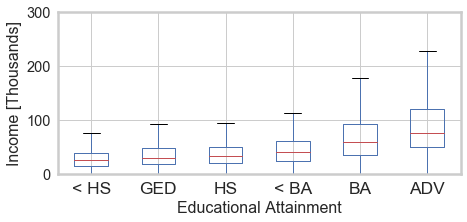

In [7]:
ax = ipums.boxplot(by = "EDUC5", column = "INCTOTK")
ax.set_ylim(0, 300)
ax.set_ylabel("Income [Thousands]")
ax.set_xlabel("Educational Attainment")
plt.suptitle("")
plt.title("")

But I think you can get more-attractive/informative results with seaborn.  In particular, seaborn makes it easy to show multiple variables/categories at once.

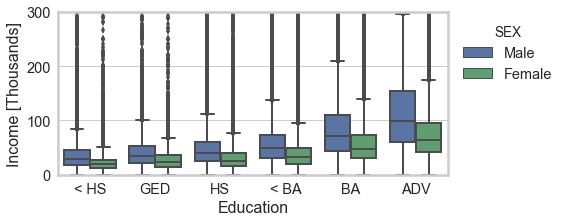

In [8]:
ax = sns.boxplot(x = "EDUC5", y = "INCTOTK", hue = "SEX", data = ipums, linewidth = 2)

ax.get_legend().set_bbox_to_anchor((1.3, 1))
ax.set_ylim(0, 300)
ax.set_ylabel("Income [Thousands]")
ax.set_xlabel("Education")

ax.figure.savefig("income_box.pdf", bbox_inches='tight', pad_inches=0.05)

An alternative that to be aware (but maybe weary?) of is a violin plot.  This will make a kernel density estimate of the variables.

The problem is that the bandwidth (`bw`) for the kernel density can dramatically affect the presentation, and you should take care so that the density does not extend in non-sensical regions (`cut`).

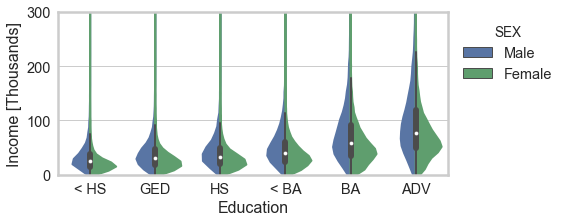

In [9]:
ax = sns.violinplot(x = "EDUC5", y = "INCTOTK", data = ipums,
                    hue = "SEX", split = True, bw = 0.1, cut = 0,
                    linewidth = 2)

ax.get_legend().set_bbox_to_anchor((1.3, 1))
ax.set_ylim(0, 300)
ax.set_ylabel("Income [Thousands]")
ax.set_xlabel("Education")

ax.figure.savefig("income_violin.pdf", bbox_inches='tight', pad_inches=0.05)

So we can see the relationships between education, sex and earnings.  Let's make this a bit more formal. 

With `statsmodels`, we can "trivially" define a weighted least squares model for log income.

In this regression, any case that is either a string (`SEX`) or a categorial (`RACE4` and `EDUC5`) will be treated as a category/fixed effect.  I've already restricted this to be positive to sidestep the log(0) problem.

In [14]:
# ols = smf.wls(formula = "np.log(INCTOT) ~ AGE + RACE4 + EDUC5 + SEX", 
ols = smf.wls(formula = "np.log(INCTOT) ~ 1", 
              data = ipums, weights = ipums["PERWT"])
model = ols.fit()
model.summary()

/Users/jsaxon/anaconda/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1396: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(INCTOT)   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Sun, 12 Nov 2017   Prob (F-statistic):                nan
Time:                        13:36:03   Log-Likelihood:            -1.7247e+06
No. Observations:             1154227   AIC:                         3.449e+06
Df Residuals:                 1154226   BIC:                         3.449e+06
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.5793      0.001   1.19e+04      0.000      10.578      10.581
==============================================================================
Omnibus:                   466950.300   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8952129.412
Skew:                          -1.470   Prob(JB):                         0.00
Kurtosis:                      16.323   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Does this make sense??  How much is that, anyway??  Looks reasonable.

In [11]:
lnw = (np.log(ipums.INCTOT) * ipums.PERWT).sum() / ipums.PERWT.sum()
lnw, np.exp(lnw)

(10.579251527275819, 39310.680417171774)

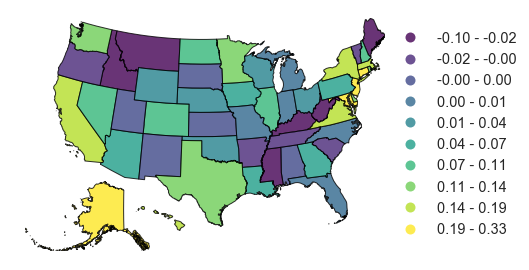

In [12]:
state_vals = {1 : 0.0}
for k, v in model.params.items():
    
    if "STATEFIP" not in k: continue
    
    f = int(k.replace("C(STATEFIP)[T.", "").replace("]", ""))
    state_vals[f] = float(v)
    
plot_states(state_vals)

### Do states with higher activity/exercise levels have lower average BMIs?

#### Behavioral Risk Factor Surveillance System

https://www.cdc.gov/brfss/annual_data/annual_2016.html

This file is about 1GB raw, so I've reduced it to what we really need:

```
cdc = pd.read_sas("data/LLCP2016.xpt", format = "xport")
cdc.rename(columns = {"_STATE" : "STATE", "_BMI5" : "BMI", "_LLCPWT" : "LLCPWT"}, inplace = True)
cdc.STATE = cdc.STATE.astype(int)
cdc[['STATE', 'BMI', 'LLCPWT', 'SEX', 'MARITAL', 'EDUCA']].to_csv("data/BRFSS_bmi_redux.csv", index = False)```

In [3]:
def weighted_mean(grp): return grp._get_numeric_data().multiply(grp['LLCPWT'], axis=0).sum()/grp['LLCPWT'].sum()

cdc = pd.read_csv("data/BRFSS_bmi_redux.csv")
cdc_bmi = cdc.groupby("STATE").apply(weighted_mean)["BMI"].reset_index()

cdc_bmi.head()

,STATE,BMI
0,1,2650.677887
1,2,2643.861457
2,4,2499.411934
3,5,2639.506359
4,6,2448.739724


In [97]:
con = sqlite3.connect("data/atus.sqlite")

state_exercise = """
SELECT 
  state_code STATE, avg(ex > 0) Exercise, count(ex) N
FROM (
  SELECT 
    state_code, 
    sum((activity_code/100 = 1301) * duration) ex 
  FROM respondents 
  JOIN activities ON
    respondents.case_id = activities.case_id
  JOIN cps ON
    respondents.case_id = cps.case_id AND
    cps.line_no = 1 
  GROUP BY respondents.case_id)
GROUP BY state_code;
"""

state_exercise = pd.read_sql_query(state_exercise, con)
state_exercise.head()

,STATE,Exercise,N
0,1,0.129404,2867
1,2,0.189911,337
2,4,0.197983,2975
3,5,0.145008,1793
4,6,0.213824,17028


In [98]:
state_ex_bmi = pd.merge(state_exercise, cdc_bmi).set_index("STATE")

We'll want a different figsize, for these.

In [4]:
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 4.5)})

NameError: name 'sns' is not defined

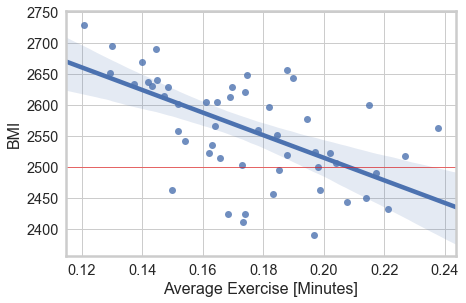

In [100]:
ax = sns.regplot(x = "Exercise", y = "BMI", data = state_ex_bmi, robust = True)
ax.set_xlabel("Average Exercise [Minutes]")
plt.plot([0, 1], [2500, 2500], 'r-', lw=0.5)

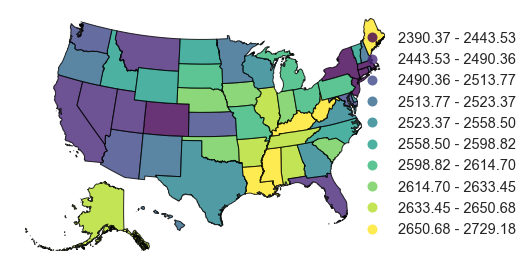

In [101]:
plot_states(state_ex_bmi["BMI"])

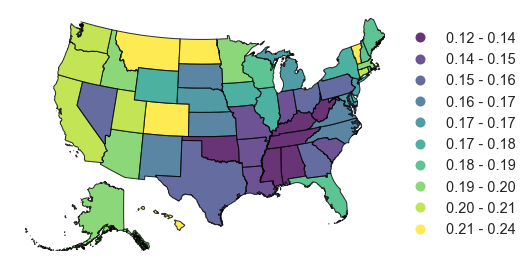

In [102]:
plot_states(state_ex_bmi["Exercise"])

In [8]:
pearsonr(state_ex_bmi["Exercise"], state_ex_bmi["BMI"])

(-0.22008570206621936, 0.12069628456994265)

### Do people exercise more on nice days?

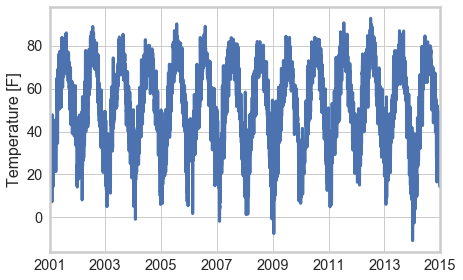

In [67]:
temp = pd.read_csv("data/MDW.csv", names = ["Date", "Temperature [F]", "Precipitation [In]"], header = 0,
                   parse_dates = ["Date"], index_col = "Date")

import pytz
temp.set_index(temp.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Central')), inplace = True)

temp = temp[temp["Temperature [F]"] > -2000].copy()
temp["Date"] = temp.index.date

temp = temp.groupby("Date").mean()[["Temperature [F]"]]

ax = temp["Temperature [F]"].plot()
ax.set_xlabel("")
ax.set_ylabel("Temperature [F]")

In [84]:
il_exercise_date = """
SELECT 
  diary_date Date,
  sum((activity_code/100 = 1301) * duration) ex 
FROM respondents 
JOIN activities ON
  respondents.case_id = activities.case_id
JOIN cps ON
  respondents.case_id = cps.case_id AND
  cps.line_no = 1 
WHERE
  state_code = 17
GROUP BY respondents.case_id;
"""

il_exercise = pd.read_sql_query(il_exercise_date, con)
il_exercise["Date"] = pd.to_datetime(il_exercise.Date, format='%Y%m%d').dt.date
il_exercise.set_index("Date", inplace = True)

In [85]:
il_ex_temp = il_exercise.join(temp).dropna()
il_ex_temp.rename(columns = {"ex" : "Exercise [Minutes]"}, inplace = True)

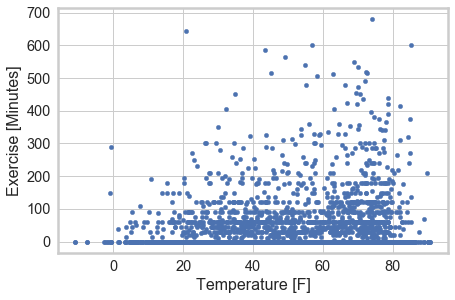

In [86]:
il_ex_temp.plot(kind = "scatter", x = "Temperature [F]", y = "Exercise [Minutes]")

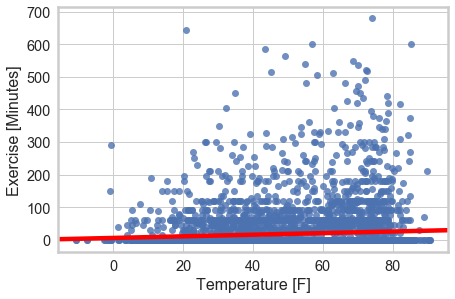

In [87]:
sns.regplot(data = il_ex_temp, x = "Temperature [F]", y = "Exercise [Minutes]", line_kws = {"color" : "red"})

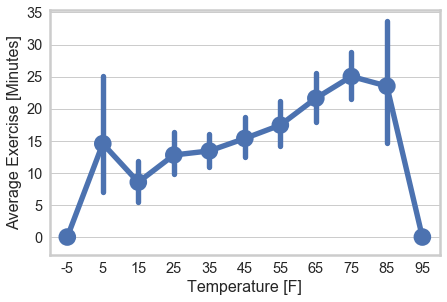

In [88]:
il_ex_temp["TempIF"] = (il_ex_temp["Temperature [F]"]/10).astype(int) * 10 + 5
ax = sns.pointplot(data = il_ex_temp, x = "TempIF", y = "Exercise [Minutes]", line_kws = {"color" : "red"})
ax.set_xlabel("Temperature [F]")
ax.set_ylabel("Average Exercise [Minutes]")

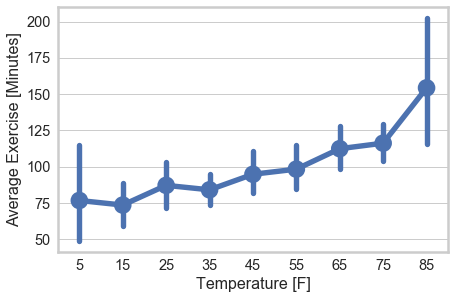

In [89]:
il_ex_temp["ExBool"] = il_ex_temp["Exercise [Minutes]"] > 0
ax = sns.pointplot(data = il_ex_temp[il_ex_temp["ExBool"]], x = "TempIF", y = "Exercise [Minutes]", line_kws = {"color" : "red"})
ax.set_xlabel("Temperature [F]")
ax.set_ylabel("Average Exercise [Minutes]")

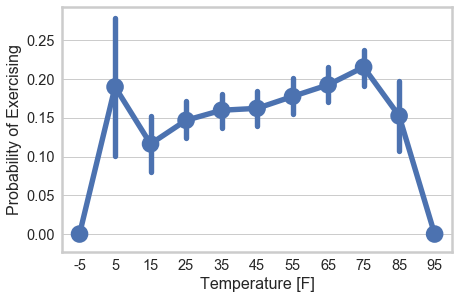

In [82]:
il_ex_temp["ExBool"] = il_ex_temp["Exercise [Minutes]"] > 0
ax = sns.pointplot(data = il_ex_temp, x = "TempIF", y = "ExBool")
ax.set_xlabel("Temperature [F]")
ax.set_ylabel("Probability of Exercising")

### Does paying attention to children help them to succeed?

In [14]:
ipums = pd.read_csv("data/ipums.csv")

In [15]:
ipums1990 = ipums.loc[(ipums.YEAR == 1990) & (ipums.PERNUM == 1) & \
                      (25 < ipums.AGE) & (ipums.AGE < 35), \
                      ["INCTOT", "STATEFIP", "EDUCD", "PERWT"]].copy()

ipums1990["HS"] = ipums1990.EDUCD > 61
ipums1990["BA"] = ipums1990.EDUCD >= 101

In [16]:
def weighted_mean(grp): return grp._get_numeric_data().multiply(grp['PERWT'], axis=0).sum()/grp['PERWT'].sum()

def weighted_inc_median(grp):

    s = grp.sort_values(by = "INCTOT")
    c = grp.loc[grp["INCTOT"] < 8e6, "PERWT"].sum() / 2.0
    q = s["PERWT"].cumsum() 
    
    median = s.loc[q >= c, "INCTOT"].iloc[0]
    
    return median


In [17]:
grouped = ipums1990.groupby("STATEFIP")
ipums1990_agg = grouped.apply(weighted_mean)[["BA", "HS"]]
ipums1990_agg = ipums1990_agg.join(pd.Series(grouped.apply(weighted_inc_median), name = "Income"))

ipums1990_agg.head()

,BA,HS,Income
STATEFIP,,,
1,0.211500,0.807734,18029
2,0.203983,0.923597,24080
4,0.238060,0.855422,20000
5,0.163828,0.803977,16213
6,0.265122,0.812731,23000


In [18]:
ipums2016 = ipums.loc[(ipums.YEAR == 2016) & (ipums.PERNUM == 1) & \
                      (25 < ipums.AGE) & (ipums.AGE < 35), \
                      ["BPL", "EDUCD", "PERWT"]].copy()

ipums2016["HS"] = ipums2016.EDUCD > 61
ipums2016["BA"] = ipums2016.EDUCD >= 101

ipums2016_agg = ipums2016.groupby("BPL").apply(weighted_mean)[["HS", "BA"]].reset_index()

In [19]:
ipums_merged = pd.merge(ipums1990_agg.rename(columns = {"HS" : "HS_home", "BA" : "BA_home", "Income" : "INC_home"}).reset_index(), 
                        ipums2016_agg, left_on = "STATEFIP", right_on = "BPL")

ipums_merged = ipums_merged.set_index("BPL")[["HS_home", "BA_home", "INC_home", "HS", "BA"]]
ipums_merged.head()

,HS_home,BA_home,INC_home,HS,BA
BPL,,,,,
1,0.807734,0.211500,18029,0.895147,0.331637
2,0.923597,0.203983,24080,0.967301,0.337315
4,0.855422,0.238060,20000,0.917187,0.317324
5,0.803977,0.163828,16213,0.915928,0.324585
6,0.812731,0.265122,23000,0.933098,0.372165


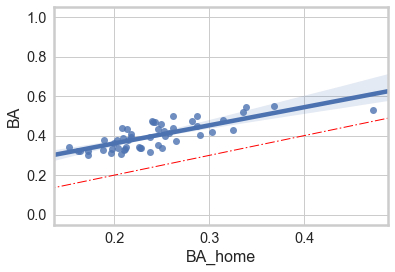

In [20]:
sns.regplot(x = "BA_home", y = "BA", data = ipums_merged)
plt.plot([0, 1], [0, 1], 'r-.', lw=1)

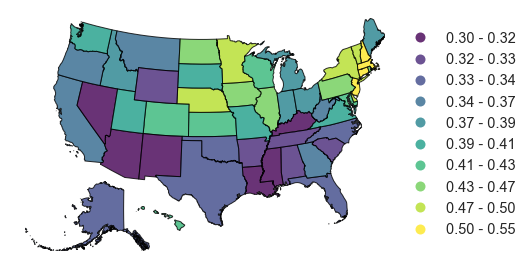

In [21]:
plot_states(ipums_merged["BA"])

In [103]:
ols = smf.ols(formula = "BA ~ BA_home + HS_home + np.log(INC_home)", data = ipums_merged)
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     BA   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     48.75
Date:                Sun, 12 Nov 2017   Prob (F-statistic):           1.81e-14
Time:                        12:15:56   Log-Likelihood:                 100.81
No. Observations:                  51   AIC:                            -193.6
Df Residuals:                      47   BIC:                            -185.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.0662      0.465     -2.293      0.026      -2.002      -0.131
BA_home                0.6515      0.118      5.515      0.000       0.414       0.889
HS_home                0.6190      0.137      4.514      0.000       0.343       0.895
np.log10(INC_home)     0.1794      0.119      1.507      0.138      -0.060       0.419
==============================================================================
Omnibus:                        1.102   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.576   Jarque-Bera (JB):                1.138
Skew:                          -0.315   Prob(JB):                        0.566
Kurtosis:                       2.627   Cond. No.                         449.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

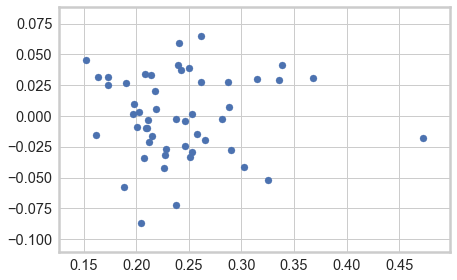

In [108]:
plt.scatter(x = ipums_merged["BA_home"], y = model.resid)

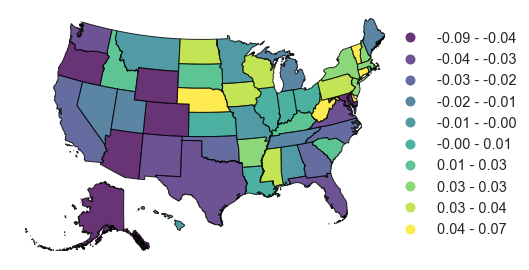

In [104]:
ipums_merged["BA Residuals"] = model.resid
plot_states(model.resid)

In [24]:
direct = """
SELECT 
  respondents.case_id,
  race, hispanic_origin as hispanic, edited_sex as sex,
  family_income, state_code, census_division,
  cps.years_education AS adult_education, 
  SUM(((activity_code/100 IN (301, 302, 303)) OR activity_code = 180381) * duration/60.) AS 'child_attention'
FROM respondents
INNER JOIN cps ON 
  respondents.case_id = cps.case_id AND 
  respondents.line_no = cps.line_no
INNER JOIN activities ON
  respondents.case_id = activities.case_id
INNER JOIN roster ON
  respondents.case_id = roster.case_id AND
  respondents.line_no = roster.line_no
WHERE
  number_of_hh_children > 0 AND
  edited_labor_force_status < 3
GROUP BY respondents.case_id;
"""

df = pd.read_sql_query(direct, con)

df["EDCAT"] = "0DROPOUT"
df.loc[df.adult_education >= 13, "EDCAT"] = "1HSGRAD"
df.loc[df.adult_education == 17, "EDCAT"] = "2BA"
df.loc[df.adult_education >  17, "EDCAT"] = "3ADV"

df.loc[df.family_income == 0, "family_income"] += 1
direct_engagement = df[df.family_income > 0].copy()

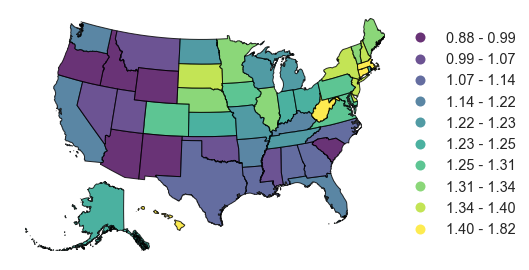

In [25]:
ipums_merged["Attention"] = direct_engagement.groupby("state_code").mean()[["child_attention"]]
plot_states(ipums_merged["Attention"])

In [26]:
ols = smf.ols(formula = "child_attention ~ C(EDCAT) + np.log(family_income) + C(state_code) + C(sex)",
              data = direct_engagement)
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        child_attention   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     62.36
Date:                Sat, 11 Nov 2017   Prob (F-statistic):               0.00
Time:                        21:57:29   Log-Likelihood:            -1.0150e+05
No. Observations:               52250   AIC:                         2.031e+05
Df Residuals:                   52194   BIC:                         2.036e+05
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.3617      0.087      4.156      0.000       0.191       0.532
C(EDCAT)[T.1HSGRAD]       0.5500      0.025     21.856      0.000       0.501       0.599
C(EDCAT)[T.2BA]           1.0351      0.028     37.073      0.000       0.980       1.090
C(EDCAT)[T.3ADV]          1.1581      0.031     37.392      0.000       1.097       1.219
C(state_code)[T.2]        0.0516      0.160      0.322      0.748      -0.263       0.366
C(state_code)[T.4]       -0.0833      0.083     -0.999      0.318      -0.247       0.080
C(state_code)[T.5]        0.0551      0.096      0.573      0.567      -0.134       0.244
C(state_code)[T.6]        0.0962      0.066      1.466      0.143      -0.032       0.225
C(state_code)[T.8]        0.1315      0.079      1.661      0.097      -0.024       0.287
C(state_code)[T.9]        0.2203      0.090      2.437      0.015       0.043       0.398
C(state_code)[T.10]       0.1940      0.142      1.367      0.172      -0.084       0.472
C(state_code)[T.11]       0.4852      0.222      2.190      0.029       0.051       0.919
C(state_code)[T.12]       0.0036      0.070      0.051      0.959      -0.134       0.142
C(state_code)[T.13]       0.0179      0.076      0.235      0.815      -0.132       0.168
C(state_code)[T.15]       0.2063      0.144      1.430      0.153      -0.077       0.489
C(state_code)[T.16]      -0.1362      0.112     -1.212      0.226      -0.356       0.084
C(state_code)[T.17]       0.1814      0.071      2.548      0.011       0.042       0.321
C(state_code)[T.18]       0.1365      0.078      1.741      0.082      -0.017       0.290
C(state_code)[T.19]       0.1601      0.086      1.866      0.062      -0.008       0.328
C(state_code)[T.20]       0.1458      0.087      1.668      0.095      -0.025       0.317
C(state_code)[T.21]       0.0698      0.084      0.830      0.406      -0.095       0.235
C(state_code)[T.22]      -0.0131      0.091     -0.143      0.886      -0.192       0.166
C(state_code)[T.23]       0.2075      0.120      1.735      0.083      -0.027       0.442
C(state_code)[T.24]       0.1020      0.080      1.270      0.204      -0.055       0.259
C(state_code)[T.25]       0.2409      0.078      3.074      0.002       0.087       0.395
C(state_code)[T.26]       0.0787      0.073      1.078      0.281      -0.064       0.222
C(state_code)[T.27]       0.1572      0.076      2.078      0.038       0.009       0.305
C(state_code)[T.28]      -0.0253      0.099     -0.256      0.798      -0.218       0.168
C(state_code)[T.29]       0.1063      0.078      1.364      0.173      -0.046       0.259
C(state_code)[T.30]      -0.0730      0.133     -0.550      0.583      -0.333       0.187
C(state_code)[T.31]       0.2134      0.099      2.153      0.031       0.019       0.408
C(state_code)[T.32]    

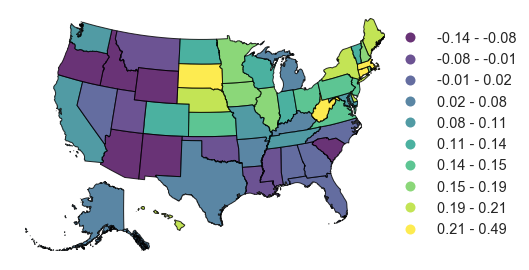

In [27]:
state_vals = {1 : 0.0}
for k, v in model.params.items():
    
    if "state_code" not in k: continue
    
    f = int(k.replace("C(state_code)[T.", "").replace("]", ""))
    state_vals[f] = float(v)
    
ipums_merged["Attention Fixed Effects"] = pd.Series(state_vals)
plot_states(state_vals)

In [28]:
ipums_merged.head()

,HS_home,BA_home,INC_home,HS,BA,BA Residuals,Attention,Attention Fixed Effects
BPL,,,,,,,,
1,0.807734,0.211500,18029,0.895147,0.331637,-0.003256,1.106261,0.000000
2,0.923597,0.203983,24080,0.967301,0.337315,-0.086936,1.236282,0.051578
4,0.855422,0.238060,20000,0.917187,0.317324,-0.072469,0.964623,-0.083267
5,0.803977,0.163828,16213,0.915928,0.324585,0.031344,1.144703,0.055135
6,0.812731,0.265122,23000,0.933098,0.372165,-0.019721,1.171354,0.096166


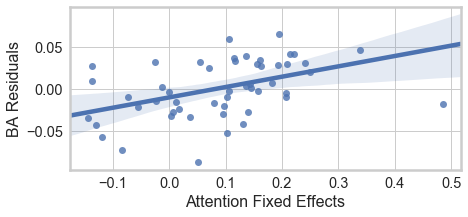

In [46]:
sns.regplot(data = ipums_merged, x = "Attention Fixed Effects", y = "BA Residuals", robust = True)

In [43]:
ols = smf.ols(formula = "BA ~ BA_home + HS_home + np.log(INC_home) + Attention", data = ipums_merged)
ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     BA   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     51.40
Date:                Sat, 11 Nov 2017   Prob (F-statistic):           2.11e-16
Time:                        22:38:45   Log-Likelihood:                 108.08
No. Observations:                  51   AIC:                            -206.2
Df Residuals:                      46   BIC:                            -196.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.0669      0.408     -2.618      0.012      -1.887      -0.247
BA_home              0.4078      0.121      3.372      0.002       0.164       0.651
HS_home              0.5415      0.122      4.445      0.000       0.296       0.787
np.log(INC_home)     0.0739      0.045      1.631      0.110      -0.017       0.165
Attention            0.1369      0.035      3.897      0.000       0.066       0.208
==============================================================================
Omnibus:                        2.496   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.287   Jarque-Bera (JB):                1.568
Skew:                          -0.353   Prob(JB):                        0.457
Kurtosis:                       3.488   Cond. No.                         979.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""